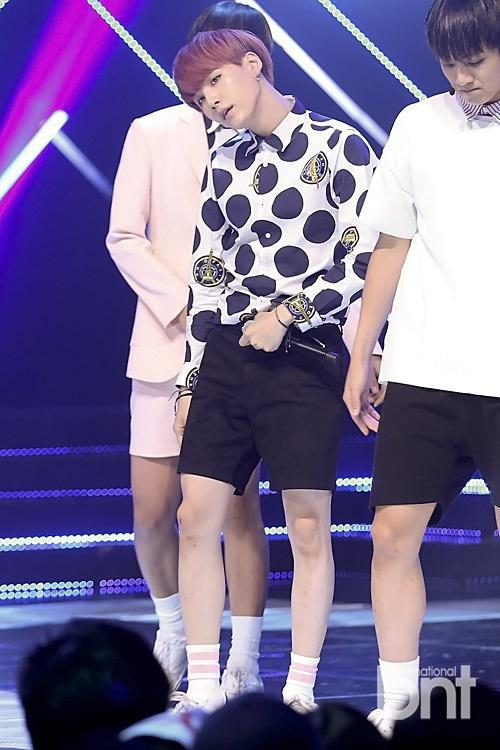

In [104]:


import glob, json, os
import random

from PIL import Image
from tqdm._tqdm_notebook import tqdm
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths = glob.glob('./data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/*.jpg')
img_paths.sort()

img_paths = img_paths[:3000]

validation_annotations = json.load(
    open('./data/ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json')
)

validation_annotations[:3000]

validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}

# 生成随机十个数

query_index_list = np.random.randint(0, 3000, 10)
query_index_list.sort()

# 字典
img_paths_basename = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basename]

index = random.choice(query_index_list)
Image.open(img_paths[index])


In [105]:

img_captions[index]

'三个穿着短裤的人站在打着灯光的舞台上'

# 加载CLIP模型 chinese-clip-vit-base-patch16

In [106]:
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

model_path = "../models/AI-ModelScope/chinese-clip-vit-base-patch16"

model = ChineseCLIPModel.from_pretrained(model_path)
processor = ChineseCLIPProcessor.from_pretrained(model_path, use_fast=True)

# model = model.to('cuda')

# 图像编码

In [107]:
img_immage_feat = []

batch_size = 10

for idx in tqdm(range(len(img_captions) // batch_size + 1)):
    img = [Image.open(path) for path in img_paths[idx * batch_size:(idx + 1) * batch_size]]

    if len(img) == 0:
        break

    imputs = processor(images=img, return_tensors='pt')

    with torch.no_grad():
        image_feature = model.get_image_features(**imputs)
        image_feature = image_feature.data.numpy()
        img_immage_feat.append(image_feature)
    if idx == batch_size:
        query_index_list = np.random.randint(0, idx * batch_size, 10)
        break

img_immage_feat = np.vstack(img_immage_feat)
img_immage_feat = normalize(img_immage_feat)

img_immage_feat.shape


  0%|          | 0/301 [00:00<?, ?it/s]

(110, 512)

# 文本编码

In [108]:


img_texts_feat = []

for idx in range(len(img_captions) // batch_size + 1):
    texts = [text for text in img_captions[idx * batch_size: (idx + 1) * batch_size]]

    if len(texts) == 0:
        break

    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)

    if idx == batch_size:
        break

img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)



# 相似度计算

输入文本:  两个穿着相同外套的女孩和一个戴着眼镜的男孩站在室内


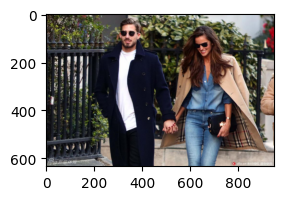

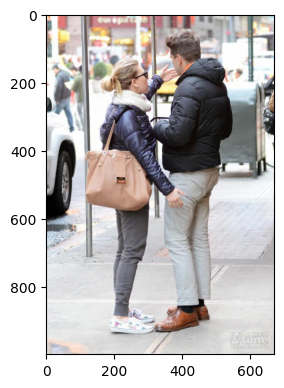

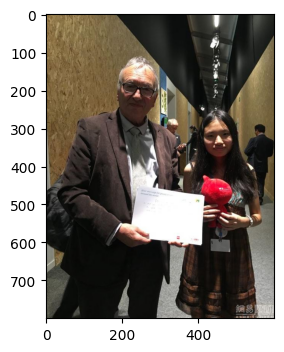

In [109]:
query_idx = random.choice(query_index_list)

sim_result = np.dot(img_texts_feat[query_idx], img_immage_feat.T)
print('输入文本: ', img_captions[query_idx])
sim_idx = sim_result.argsort()[::-1][1:6]

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(Image.open(img_paths[sim_idx[0]]))

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 2)
plt.imshow(Image.open(img_paths[sim_idx[1]]))

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 3)
plt.imshow(Image.open(img_paths[sim_idx[2]]))




# 文本标签编码

In [110]:
import jieba

jieba.lcut(img_captions[query_idx])

img_captions2words = [jieba.lcut(x) for x in img_captions]

img_captions2words = sum(img_captions2words, [])

img_captions2words = [x for x in img_captions2words if len(x) > 1]

img_captions2words = list(set(img_captions2words))

img_texts_feat = []
for idx in tqdm(range(len(img_captions2words) // batch_size + 1)):
    
    texts = [text for text in img_captions2words[idx * batch_size:(idx + 1) * batch_size]]
    
    if len(texts) == 0:
        break
        
    inpust  = processor(text=texts, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)   
        
    if idx == batch_size:
        break
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)


  0%|          | 0/163 [00:00<?, ?it/s]

# 标签相似度计算

文本识别结果:  ['起跑', '耳边', '旗帜', '打招呼', '橡皮艇']


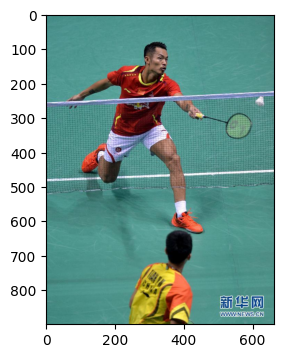

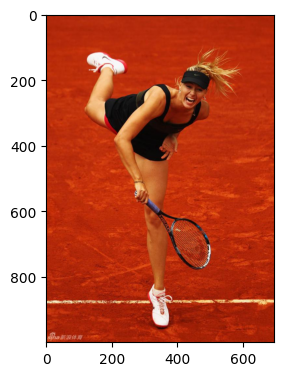

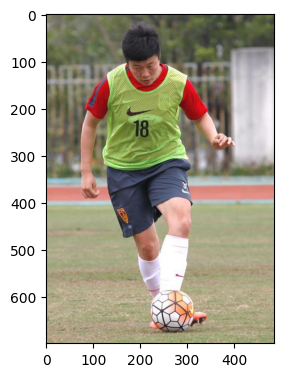

In [111]:

query_idx = random.choice(query_index_list)

sim_result = np.dot(img_texts_feat[query_idx], img_immage_feat.T)
sim_idx = sim_result.argsort()[::-1][1:6]

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(Image.open(img_paths[sim_idx[0]]))

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 2)
plt.imshow(Image.open(img_paths[sim_idx[1]]))

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 3)
plt.imshow(Image.open(img_paths[sim_idx[2]]))

